In [39]:
from tensorflow.keras.models import load_model, Model

# Load the saved models
base_model1 = load_model("ResNet50_93.15.h5")
base_model2 = load_model("InceptionV3_96.15.h5")
base_model3 = load_model("MobileNet.h5")

In [40]:
base_model1 = Model(inputs=base_model1.inputs,
                outputs=base_model1.outputs,
                name='ResNet50')

base_model2 = Model(inputs=base_model2.inputs,
                outputs=base_model2.outputs,
                name='InceptionV3')

base_model3 = Model(inputs=base_model3.inputs,
                outputs=base_model3.outputs,
                name='MobileNet')

In [41]:
# Compile the model with the same settings used for training

base_model1.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

base_model2.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

base_model3.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folders = os.listdir(data_dir)
    for folder in folders:
        folder_path = os.path.join(data_dir, folder)
        files = os.listdir(folder_path)
        for file in files:
            fpath = os.path.join(folder_path, file)
            filepaths.append(fpath)
            labels.append(folder)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [5]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    tr_gen = ImageDataGenerator(preprocessing_function= None)
    ts_gen = ImageDataGenerator(preprocessing_function= None)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= batch_size)

    return train_gen, valid_gen, test_gen

In [6]:
data_dir = './Pill Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


# ResNet50 Evaluation

In [7]:
# Evaluation for ResNet50 base model

train_eval = base_model1.evaluate(train_gen, verbose= 1)
valid_eval = base_model1.evaluate(valid_gen, verbose= 1)
test_eval = base_model1.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_eval[0])
print("Train Accuracy: ", train_eval[1])
print('-' * 20)
print("Validation Loss: ", valid_eval[0])
print("Validation Accuracy: ", valid_eval[1])
print('-' * 20)
print("Test Loss: ", test_eval[0])
print("Test Accuracy: ", test_eval[1])

50/50 [==============================] - 129s 3s/step - loss: 0.2172 - accuracy: 0.9315
Train Loss:  0.1911136955022812
Train Accuracy:  0.9365000128746033
--------------------
Validation Loss:  0.24592754244804382
Validation Accuracy:  0.9139999747276306
--------------------
Test Loss:  0.2172316014766693
Test Accuracy:  0.9315000176429749


In [8]:
preds = base_model1.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\DELL\AppData\Local\Temp\ipykernel_18816\1420746166.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = base_model1.predict_generator(test_gen)


[1 6 8 ... 4 4 8]


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(test_gen.classes, y_pred, average = 'weighted')
print(f"Precision Score = {precision}")

# Calculate recall
recall = recall_score(test_gen.classes, y_pred, average = 'weighted')
print(f"Recall Score = {recall}")

# Calculate F1-score
f1 = f1_score(test_gen.classes, y_pred, average = 'weighted')
print(f"F1 Score = {f1}")

Precision Score = 0.9344721539797133
Recall Score = 0.9315
F1 Score = 0.9318283794618715


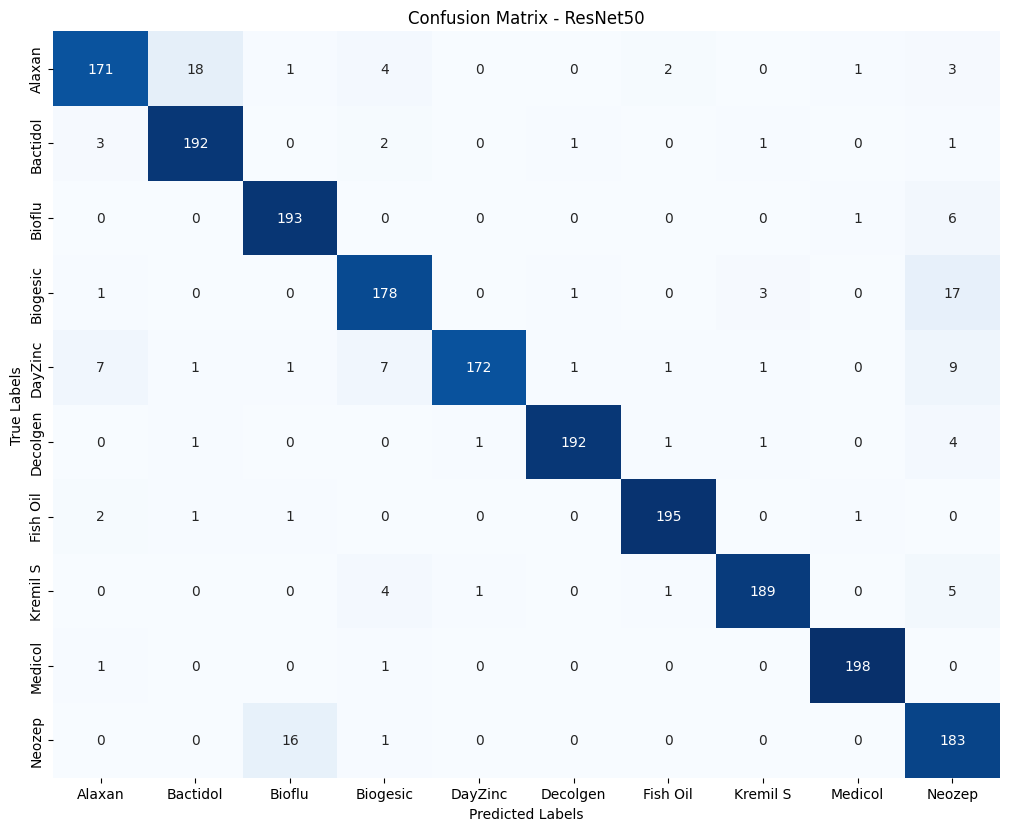

              precision    recall  f1-score   support

      Alaxan       0.92      0.85      0.89       200
    Bactidol       0.90      0.96      0.93       200
      Bioflu       0.91      0.96      0.94       200
    Biogesic       0.90      0.89      0.90       200
     DayZinc       0.99      0.86      0.92       200
    Decolgen       0.98      0.96      0.97       200
    Fish Oil       0.97      0.97      0.97       200
    Kremil S       0.97      0.94      0.96       200
     Medicol       0.99      0.99      0.99       200
      Neozep       0.80      0.92      0.86       200

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Inception-V3 Evaluation

In [13]:
# Evaluation for InceptionV3 base model

train_eval_2 = base_model2.evaluate(train_gen, verbose= 1)
valid_eval_2 = base_model2.evaluate(valid_gen, verbose= 1)
test_eval_2 = base_model2.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_eval_2[0])
print("Train Accuracy: ", train_eval_2[1])
print('-' * 20)
print("Validation Loss: ", valid_eval_2[0])
print("Validation Accuracy: ", valid_eval_2[1])
print('-' * 20)
print("Test Loss: ", test_eval_2[0])
print("Test Accuracy: ", test_eval_2[1])

50/50 [==============================] - 83s 2s/step - loss: 0.1073 - accuracy: 0.9615
Train Loss:  0.06266392767429352
Train Accuracy:  0.9793124794960022
--------------------
Validation Loss:  0.10889683663845062
Validation Accuracy:  0.965499997138977
--------------------
Test Loss:  0.10730096697807312
Test Accuracy:  0.9614999890327454


In [27]:
preds_2 = base_model2.predict(test_gen)
y_pred_2 = np.argmax(preds_2, axis=1)
print(y_pred_2)

50/50 [==============================] - 67s 1s/step
[1 6 8 ... 4 4 2]


In [32]:
# Calculate precision
precision_2 = precision_score(test_gen.classes, y_pred_2, average = 'weighted')
print(f"Precision Score = {precision_2}")

# Calculate recall
recall_2 = recall_score(test_gen.classes, y_pred_2, average = 'weighted')
print(f"Recall Score = {recall_2}")

# Calculate F1-score
f1_2 = f1_score(test_gen.classes, y_pred_2, average = 'weighted')
print(f"F1 Score = {f1_2}")

Precision Score = 0.9625595719680691
Recall Score = 0.9615
F1 Score = 0.961532590656724


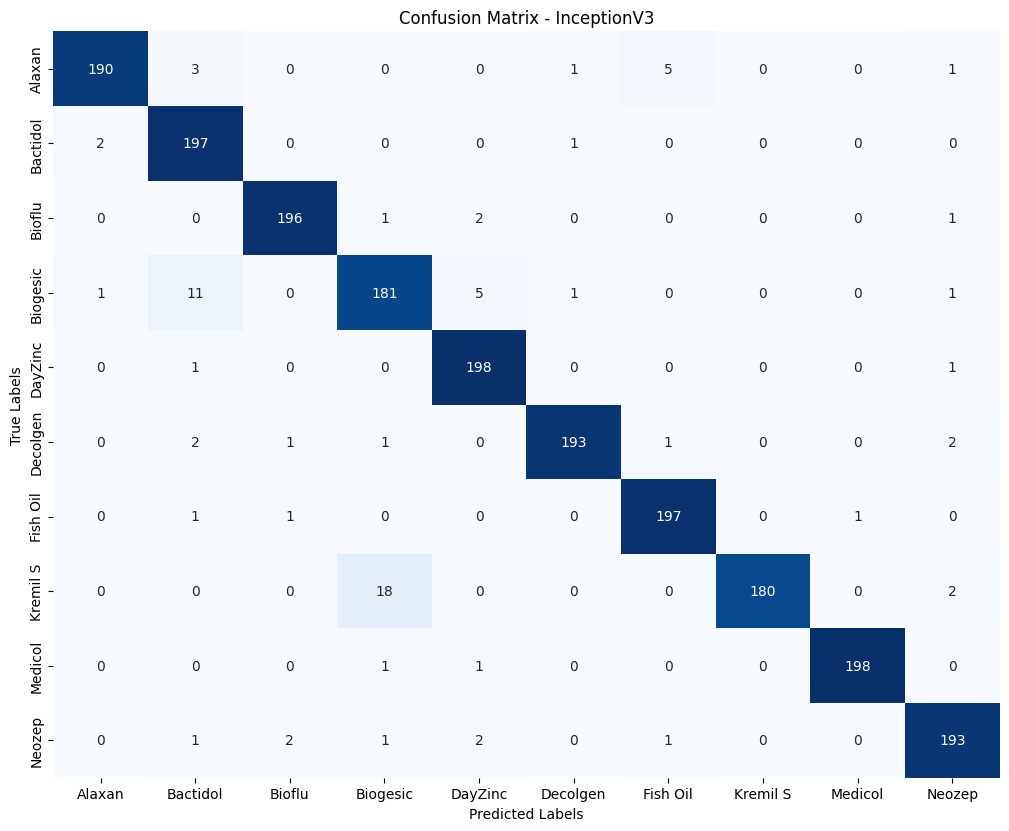

              precision    recall  f1-score   support

      Alaxan       0.98      0.95      0.97       200
    Bactidol       0.91      0.98      0.95       200
      Bioflu       0.98      0.98      0.98       200
    Biogesic       0.89      0.91      0.90       200
     DayZinc       0.95      0.99      0.97       200
    Decolgen       0.98      0.96      0.97       200
    Fish Oil       0.97      0.98      0.98       200
    Kremil S       1.00      0.90      0.95       200
     Medicol       0.99      0.99      0.99       200
      Neozep       0.96      0.96      0.96       200

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [31]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred_2)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred_2, target_names= classes))

# MobileNet Evaluation

In [42]:
# Evaluation for MobileNet base model

train_eval_3 = base_model3.evaluate(train_gen, verbose= 1)
valid_eval_3 = base_model3.evaluate(valid_gen, verbose= 1)
test_eval_3 = base_model3.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_eval_3[0])
print("Train Accuracy: ", train_eval_3[1])
print('-' * 20)
print("Validation Loss: ", valid_eval_3[0])
print("Validation Accuracy: ", valid_eval_3[1])
print('-' * 20)
print("Test Loss: ", test_eval_3[0])
print("Test Accuracy: ", test_eval_3[1])

50/50 [==============================] - 32s 633ms/step - loss: 0.2521 - accuracy: 0.9285
Train Loss:  0.13772165775299072
Train Accuracy:  0.9570000171661377
--------------------
Validation Loss:  0.26090648770332336
Validation Accuracy:  0.9169999957084656
--------------------
Test Loss:  0.25206711888313293
Test Accuracy:  0.9284999966621399


In [43]:
preds_3 = base_model3.predict(test_gen)
y_pred_3 = np.argmax(preds_3, axis=1)
print(y_pred_3)

50/50 [==============================] - 30s 598ms/step
[1 6 8 ... 4 4 4]


In [44]:
# Calculate precision
precision_3 = precision_score(test_gen.classes, y_pred_3, average = 'weighted')
print(f"Precision Score = {precision_3}")

# Calculate recall
recall_3 = recall_score(test_gen.classes, y_pred_3, average = 'weighted')
print(f"Recall Score = {recall_3}")

# Calculate F1-score
f1_3 = f1_score(test_gen.classes, y_pred_3, average = 'weighted')
print(f"F1 Score = {f1_3}")

Precision Score = 0.9314079227385582
Recall Score = 0.9285
F1 Score = 0.9287226755364063


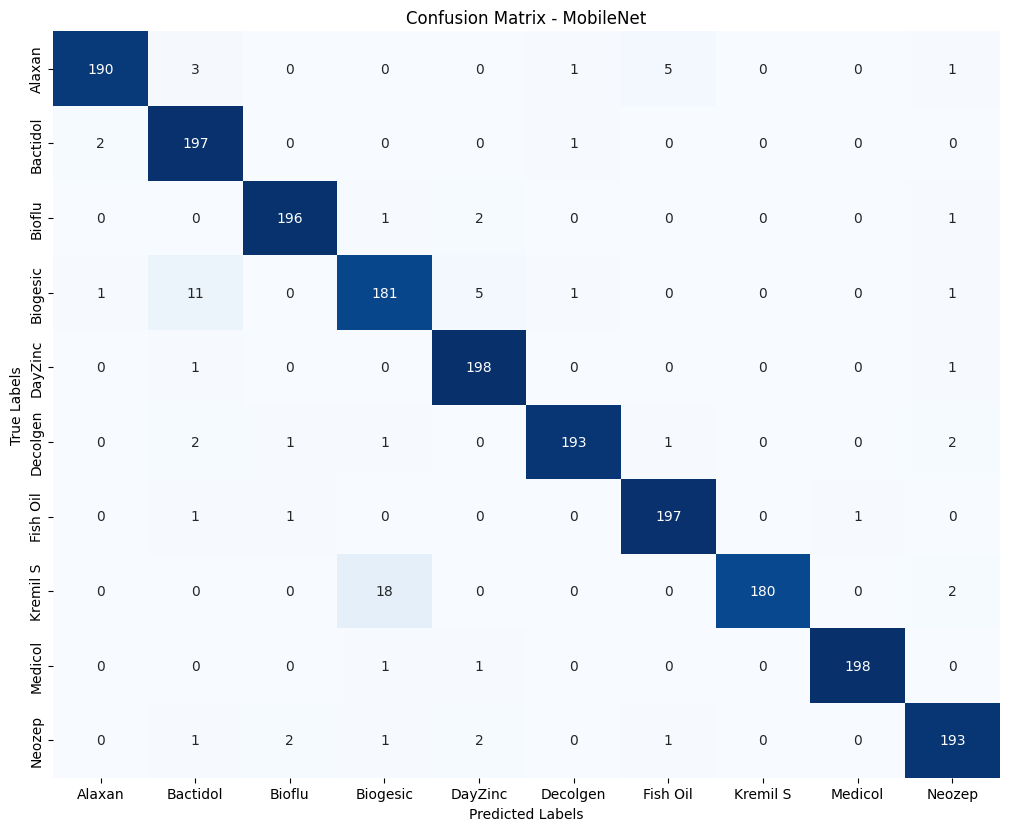

              precision    recall  f1-score   support

      Alaxan       0.91      0.92      0.91       200
    Bactidol       0.97      0.86      0.92       200
      Bioflu       0.95      0.94      0.94       200
    Biogesic       0.90      0.88      0.89       200
     DayZinc       0.84      0.99      0.91       200
    Decolgen       0.97      0.92      0.95       200
    Fish Oil       0.96      0.95      0.96       200
    Kremil S       0.95      0.91      0.93       200
     Medicol       0.98      0.97      0.98       200
      Neozep       0.87      0.94      0.90       200

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [45]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred_2)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNet')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred_3, target_names= classes))